卷积神经网络是深度学习中最经典的模型之一。它巧妙地利用很少的权重却达到了全连接网络实现不了的效果。
# 全连接网络的局限性
在mnist多层分类中，仅使用一个28x28像素的小图片数据集就完成了分类任务。但在实际应用中要处理的图片像素一般都是1024，甚至更大。如果只有两个隐藏层，每层各用了256个节点，则MNIST数据集所需要的参数是(28x28x256+256x256+256x10)个w,再加上(256+ 256 +10)个b。

1. 图像变大导致色彩数变多，不好解决
如果换为1000像素，仅一层就需要1000x1000x256$ \approx $2亿个W。这只是灰度图，如果是RGB的真彩色图，再乘以3约等于6亿。如果再加上更多层，需要的学习参数将是非常多的，不仅消耗大量的内存，同时也需要大量的运算。

2. 不便处理高维数据
对于比较复杂的高维数据，如果按照全连接的方法，则只能通过增加节点、增加层数的方式来解决。而增加节点会引起参数过多的问题。因为由于隐藏层神经网络使用的是Sigmoid或Tanh激活函数，其反向传播的有效层数也只能在4~6层左右。所以，层数再多只会使反向传播的修正值越来越小，网络无法训练。

而卷积网络使用了**参数共享的方式**，换了一个角度来解决问题，不仅在准确率上大大提升，也把参数维度降了下来。

# 理解卷积神经网络
卷积网络避免了对参数的过度依赖，相比全连接神经网络，能更好地识别高维数据。
![sobel算子](imgs/17_sobel.png)上图为sobel算子对图片处理后的效果，它可以把图片的轮廓显示出来。它其实是一个很简单的矩阵计算。![](imgs/17_matrix_cal.png)图中5x5矩阵可以理解为图（小女孩原图），经过卷及操作后，变为轮廓图。
整个过程步骤如下：
1. 在外面补了一圈0，这个过程叫做padding，目的是为了变换后生成同样大小的矩阵。
2. 将3x3的矩阵中的每个元素分别与3x3矩阵对应位置上的元素相乘，然后再相加，这样得到的值作为图b的第一个元素。
3. 中间的3x3矩阵就是sobel算子。
4. 把图a中左上角的3x3矩阵向右移动一个格子，这可以理解为步长为1.
5. 将图a矩阵中的每个元素分别与中间的3x3矩阵对应位置上的元素相乘然后进行加和运算，算出的值填到图b的第二个元素里。
6. 一直重复上述操作，直到将图b中的值都填满，整个过程就叫做卷积。 

sobel可以理解为卷积神经网络里的卷积核（也可以叫做“滤波器”，filter），它里面的值也可以理解为权重w。在sobel中，这些w是固定的，就相当于一个训练好的模型，只要通过里面的值变换后的图片，就会产生具有轮廓的效果。这个变换后的图片，在卷积神经网络里称为**feature map**。

> 新生成的图片里面的每个像素值并不能保证在0~256之间。对于在区间外的像素点会导致灰度图无法显示，所以还需要做一次归一化，然后每个值都乘以256，再将所有的值映射到这个区间内。归一算法为：x=(x-Min) / (Max - Min)。其中，Max与Min为整体数据里的最大值和最小值，x是当前要转换的像素值。归一化之后可以保证每个x都在[0,1]的区间内。

# 网络结构
卷积神经网络的结构与全连接网络相比复杂很多。它的网络结构主要包括**卷积层、池化层**。细节可以分为**滤波器、步长、卷及操作、池化操作**。
## 网络结构描述
前面讲述的是一个基本原理，实际的卷积操作会复杂一些，对于一幅图片一般会使用多个卷积核（滤波器），将它们统一放到卷积层里来操作，**这一层中有几个滤波器，就会得到几个feature map**，接着还要经理一个池化层（pooling），将生成的feature map缩小（降维）。下图为一个神经网络中一个标准的卷积操作组合。![](imgs/17_convolution_network.png) 图中卷积层里面有channel的个数代表卷积层的深度。池化层中则只有一个滤波器(fileter)，主要参数是尺寸大小(即步长大小)。一个卷积网络的完整结构，如图：![](imgs/17_convolution_fully_network.png) 
一个卷积神经网络里面包括**5部分**--**输入层、若干个卷积操作和池化层结合的部分、全局平均池化层、输出层**：
- 输入层：将每个像素代表一个特征节点输入进来。
- 卷积操作部分：由多个滤波器组合的卷积层。
- 池化层：将卷积结果降维。
- 全局平均池化层：对省城的feature map取全局平均值。
- 输出层：需要分成几类，相应的就会有几个输出节点。每个输出节点都代表当前样本属于的该类型的概率。

> 全局平均池化层是后出的技术，在以前的教材里，这个位置通过是使用1~3个全连接层来代替。全连接层的劣势在于会产生大量的计算，需要大量的参数，但在效果上却和全局平均池化层一样。所以，直接使用效率更高的全局平均池化层。

# 卷积操作
卷积分为**窄卷积、全卷积和同卷积**。

1. 步长
步长是卷积操作的核心。通过步长的变换，可以得到想要的不同类型的卷积操作。![卷积](imgs/17_Narrow convolution.png)图中5x5大小的矩阵代表图片，每个图片右侧的3x3矩阵代表卷积核，最右侧的3x3矩阵为计算完的结果feature map。

卷积操作仍然是将卷积核（filter）对应的图片（image）中的矩阵数据--相乘，再相加。第一行feature map中的第一个元素，是由image块中前3行3列中的每个元素与filter中对应元素相乘再相加得到的(4=1x1+1x0+1x1+0x0+1x1+1x0+0x1+0x0+1)

步长（stride）表示卷积核在图片上移动的格数。
- 当步长为1情况下，第二行右边的feature map块里的第二个元素3，是由卷积核计算完第一个元素4，右移一格后计算得来的，相当于图片中的前3行和第1到第4列围成的3x3矩阵与卷积核各对应元素进行相乘相加操作。
- 当步长为2的情况下，就代表每次移动2格，最终会得到一个图中第二行左边的2x2矩阵块的结果。


2. 窄卷积
窄卷积(valid卷积)，即生成的feature map比原来的原始图片小，它的步长是可变的。假如滑动步长为S，原始图片的维度为N1xN1，那么卷积核的大小为N2xN2，卷积后的图像大小(N1-N2)/S+1x(N1-N2)/S+1。

3. 同卷积
同卷积(same卷积)，代表的意思是卷积后的图片尺寸与原始图片尺寸一样大，同卷积步长是固定的，滑动步长为1.一般操作时都要使用padding技术（外围补一圈0，以确保生成的尺寸不变）。

4. 全卷积
全卷积（full卷积），也叫反卷积，就是把原始图片里的每个像素点都用卷积操作展开。![](imgs/17_full_convolution.png)
图中，白色的块是原始图片，浅色的是卷积核，深色的是正在卷积操作的像素点。反卷积操作的过程中，同样需要对原有图片进行padding操作，生成的结果会比原有的图片尺寸大。 全卷积的步长也是固定的，滑动步长为1，加入原始图片的维度为N1xN1,那么卷积核的大小为N2xN2，卷积后的图像大小，即N1+N2xN1+N2-1

窄卷积和同卷积都是卷积网络里常用的技术，然而全卷积（full卷积）却相反，它更多地用在反卷积网络中。

5. 反向传播
反向传播的核心步骤主要有两步：
- 反向将误差传到前面一层。
- 根据当前的误差对应的学习参数表达式，计算出其需要更新的差值。

反向求导，仍然使用链式求导法则，找到是误差最小化的梯度，再配合学习率算出更新的差值。将生成的feature map做一次padding后，与转置后的卷积核做一次卷积操作即可得到输入端的误差，从而实现误差的反向传递。

6. 多通道卷积

通道（Channel），是指图片中每个像素由几个数来表示，这几个数一般指的是色彩。比如一个灰度图的通道就是1，一个彩色图的通道就是3（红黄蓝）。

在卷积神经网络里，通道又分为**输入通道**和**输出通道**。
- 输入通道：就是图片的通道。如果是彩色图片，起始的输入通道就是3.如果是中间层的卷积，输入通道就是上一层的输出通道个数，计算方法是，每个输入通道的图片都使用同一个卷积核进行卷积操作，生成与输入通道匹配的feature map（比如彩色图片就是3个），然后再把这几张feature map相同位置上的值加起来，生成一张feature map。

- 输出通道：**想要输出几个feature map，就放几个卷积核，就是几个输出通道**。

# 池化层
池化的主要目的是降维，即在保持原有特征基础上最大限度地将数组的维数变小。

池化的操作外表跟卷积很像，只是算法不同：
- 卷积是将对应像素上的点相乘，然后相加。
- 池化中只关心滤波器的尺寸，不考虑内部的值。算法是，滤波器营社区与内的像素点取平均值或最大值。
池化步骤也有步长，这一点与卷积是一样的。

1.均值池化

在图片上对应出滤波器大小的区域，对立面的所有不为0的像素点取均值。这种方法得到的特征数据会对背景信息更敏感一些。
> 一定是不为0的像素点，这个很重要。如果把带0的像素点加上，则会增加分母，从而使整体数据变低。

2.最大池化

最大池化就是在图片上随影出滤波器大小的区域，将里面的所有像素点取最大值。这种方法得到的特征数据会对纹理特征的信息更敏感一些。

3.反向传播

池化的反向传播要比卷积容易理解。对于最大池化，直接将其误差还原到对应的位置，其他用0填入；对于均值池化，则是将其误差全部填入该像素对应的池化区域。

# 卷积神经网络的相关函数
在TensorFlow中，使用tf.nn.conv2d来实现卷积操作，使用tf.nn.max_pool来进行最大池化操作。通过传入不同的参数，来实现各种不同类型的卷积与池化操作。
## 卷积函数tf.nn.conv2d
TensorFlow中使用tf.nn.conv2d来实现卷积，格式如下：
___
```python
tf.nn.conv2d(input,filter,strides,padding,use_cudnn_on_gpu=None,name=None)
```
___
除去参数name用以指定该操作的name，与方法有关的共有5个参数。
- input:指需要做卷积的输入图像，它要求是一个Tensor，具有[batch,in_height,in_width,in_channels]这样的形状(shape)，具体含义是“训练时一个batch的图片数量，图片高度，图片宽度，图像通道数”，注意这是一个四维的Tensor，要求类型为float32和float64其中之一。
- filter:相当于CNN中的卷积核，它要求是一个Tensor，具有[filter_height,filter_width,in_channels,out_channels]这样的shape，具体含义是“卷积核的高度，滤波器的宽度，图像通道数，滤波器个数”，要求类型与参数input相同。有一个地方需要注意，第三维in_channels，就是参数input的第四维。
- strides:卷积时在图像每一维的步长，这是一个**一维的向量，长度为4**。
- padding:定义元素边框与元素内容之间的空间。string类型的量，只能是SAME和VALID其中之一，这个值决定了不同的卷积方式，padding的值为“VALID”时，表示边缘不填充，当其为“SAME”时，表示填充到滤波器可以到达图像边缘。
- use_cudnn_on_gpu:bool类型，是否使用cudnn加速，默认为true。
- 返回值：tf.nn.conv2d函数结果返回一个Tensor，这个输出就是常说的feature map。

> 在卷积函数中，padding参数是最容易引起歧义的，该参数仅仅决定是否需要补0，因此一定要清楚padding设为SAME的真正含义。在设为SAME的情况下，只有在步长为1时生成的feature map才会与输入值相等。

## padding规则介绍
padding属性的意义是定义**元素边框与元素内容**之间的空间。

在tf.nn.conv2d函数中，当变量padding为VALID和SAME时，分别由不同的算法计算。先来定义几个变量：
- 输入的尺寸中高和宽定义成in_height、in_width。
- 卷积核的高和宽定义成filter_height、filter_width。
- 输出的尺寸中高和宽定义成output_height、output_width。
- 步长的高宽方向定义成strides_height、strides_width。

### 1.VALID情况
输出宽和高的公式代码分别为：
___
```python
output_width = (in_width-filter_width + 1) / strides_width（结果向上取整）
output_height = (in_height-filter_height + 1) / strides_height（结果向上取整）

```
___

### 2.SAME情况
输出的宽和高将与卷积核没有关系，具体公式如下：
___
```python
out_height= in_height / strides_height(结果向上取整)
out_width = in_width / strides_width(结果向上取整)
```
___

补零的规则：
___
```python
pad_height = max((out_height-1)x strides_height + filter_height-in_height,0)
pad_width = max((out_width-1)x strides_width + filter_width-in_width,0)
pad_top = pad_height / 2
pad_bottom = pad_height - pad_top
pad_left = pad_width / 2
pad_right = pad_width-pad_left
```
___

- pad_height:代表高度方向要填充0的行数。
- pad_width：代表宽度方向要填充0的列数。
- pad_top、pad_bottom、pad_left、pad_right:分别代表上、下、左、右4个方向填充0的行、列数。

### 3.规则举例
假设用"一个以为数据来举例"，输入时13，filter是6，步长是5，对于padding的取值有如下表示：
___
'VALID'相当于padding，生成宽度为(13-6+1) / 5 = 2(向上取整)个数字。
inputs:  1 2 3 4 5 6 7 8 9 10 11 (12 13)
        |__________|           dropped
              |____________| 
___

'SAME'=相当于padding，生成的宽度为13/5=3（向上取整）个数字。
padding的方式可以如下计算：
___
```python
pad_width = (3-1)x5+6-13 = 3
pad_left = pad_width/2=3/2=1
pad_right= pad_width-pad_left=2
```
___
在左边补一个0，右边补2个0。
![](imgs/17_same_convolution.png)

# 卷积函数的使用
## 实例描述
通过手动生成一个5x5的矩阵来模拟图片，定义一个2x2的卷积核，来测试tf.nn.conv2d函数里的不同参数，验证其输出结果。
1. 定义输入变量。
2. 定义卷积核变量。
3. 定义卷积操作。
4. 运行卷积操作。

### 1.定义输入变量
定义3个输入变量用来模拟输入图片，分别是5x5大小1个通道的矩阵、5x5大小2个通道的矩阵、4x4大小1个通道的矩阵，并将里面的值统统赋为1。

In [3]:
import tensorflow as tf
# [batch,in_height,in_width,in_channels][训练时一个批次的图片数量，图片高度，图片宽度，图像通道数]

input1 = tf.Variable(tf.constant(1.0,shape=[1,5,5,1]))
input2 = tf.Variable(tf.constant(1.0,shape=[1,5,5,2]))
input3 = tf.Variable(tf.constant(1.0,shape=[1,4,4,1]))

### 2.定义卷积核变量
定义5个卷积核，每个卷积核都是2x2的矩阵，只是输入、输出的通道数有差别，分别是1ch输入、1ch输出，1ch输入、2ch输出，1ch输入、3ch输出，2ch输入、2ch输出，2ch输入、1ch输出，并分别在里面填入指定数值。

In [4]:
# [filter_height,filter_width,in_channels,out_channels](卷积核高度，卷积核宽度，图像通道数，卷积核个数)
filter1 = tf.Variable(tf.constant([-1.0,0,0,-1],shape=[2,2,1,1]))
filter2 = tf.Variable(tf.constant([-1.0,0,0,-1,-1.0,0,0,-1],shape=[2,2,1,2]))
filter3 = tf.Variable(tf.constant([-1.0,0,0,-1,-1.0,0,0,-1,-1.0,0,0,-1],shape=[2,2,1,3]))
filter4 = tf.Variable(tf.constant([-1.0,0,0,-1,
                                  -1.0,0,0,-1,
                                  -1.0,0,0,-1,
                                  -1.0,0,0,-1],shape=[2,2,2,2]))
filter5 = tf.Variable(tf.constant([-1.0,0,0,-1,-1.0,0,0,-1],shape=[2,2,2,1]))

### 3. 定义卷积操作
将步骤1的输入与步骤2的卷积核组合起来，建立8个卷积操作。

In [7]:
#padding的值为"VALID",表示边缘不填充；当其为“SAME”时，表示填充到卷积核可以到达图像边缘
op1 = tf.nn.conv2d(input1,filter1,strides=[1,2,2,1],padding='SAME') # 1个通道输入，生成1个feature map
op2 = tf.nn.conv2d(input1,filter2,strides=[1,2,2,1],padding='SAME') # 1个通道输入，生成2个feature map
op3 = tf.nn.conv2d(input1,filter3,strides=[1,2,2,1],padding='SAME') # 1个通道输入，生成3个feature map
op4 = tf.nn.conv2d(input2,filter4,strides=[1,2,2,1],padding='SAME') # 2个通道输入，生成2个feature map
op5 = tf.nn.conv2d(input2,filter5,strides=[1,2,2,1],padding='SAME') # 2个通道输入，生成1个feature map

vop1 = tf.nn.conv2d(input1,filter1,strides=[1,2,2,1],padding='VALID') #5x5 对于padding不同而不同
op6 = tf.nn.conv2d(input3,filter1,strides=[1,2,2,1],padding='SAME')
vop6 = tf.nn.conv2d(input3,filter1,strides=[1,2,2,1],padding='VALID') # 4x4与padding无关

（1）演示padding补0的情况
op1使用了padding=SAME的一个通道输入、一个通道输出的卷积操作，步长为2x2，按前面的函数介绍，这种情况TensorFlow会对input补0.通过公式计算，会生成3x3大小的矩阵，并且在右侧和下侧各补一圈0，由5x5矩阵变成6x6矩阵。
![](imgs/17_padding_code.png)
（2）演示多通道输出时的内存排列
op2示例了1个通道生成2个输出，op3示例了1个通道生成3个输出，可以看下它们在内存中的排列样子。
（3）演示卷积核对多通道输入的卷积处理
op4示例了2个通道生成2个输出，op5示例了2个通道生成1个输出，比较对于2个通道的卷积结果，观察是多通道的结果叠加，还是每个通道单独对应一个卷积核进行输出。
（4）验证不同尺寸下的输入受到padding为SAME何VALID的影响。

op1和vop1示例了5x5尺寸输入在padding为SAME和VALID时的变化情况，op6和vop6示例了4x4尺寸输入在padding为SAME和VALID下的变化情况。

### 4.运行卷积操作
下面把这些结果打印出来。

In [10]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    print("op1:\n",sess.run([op1,filter1])) # 1-1 后面补0
    print("-------------")
    
    print("op2:\n",sess.run([op2,filter2])) # 1-2多核卷积 按列取
    print("op3:\n",sess.run([op3,filter3])) # 1-3一个输入，3个输出
    print("-------------")
    
    print("op4:\n",sess.run([op4,filter4])) # 2-2 通道叠加 
    print("op5:\n",sess.run([op5,filter5])) # 2-1 两个输入，一个输出
    print("-------------")
    
    print("op1:\n",sess.run([op1,filter1])) # 1-1一个输入，一个输出
    print("vop1:\n",sess.run([vop1,filter1]))
    print("op6:\n",sess.run([op6,filter1]))
    print("vop6:\n",sess.run([vop6,filter1]))

op1:
 [array([[[[-2.],
         [-2.],
         [-1.]],

        [[-2.],
         [-2.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.]]]], dtype=float32), array([[[[-1.]],

        [[ 0.]]],


       [[[ 0.]],

        [[-1.]]]], dtype=float32)]
-------------
op2:
 [array([[[[-2., -2.],
         [-2., -2.],
         [-2.,  0.]],

        [[-2., -2.],
         [-2., -2.],
         [-2.,  0.]],

        [[-1., -1.],
         [-1., -1.],
         [-1.,  0.]]]], dtype=float32), array([[[[-1.,  0.]],

        [[ 0., -1.]]],


       [[[-1.,  0.]],

        [[ 0., -1.]]]], dtype=float32)]
op3:
 [array([[[[-2., -2., -2.],
         [-2., -2., -2.],
         [-1., -1., -1.]],

        [[-2., -2., -2.],
         [-2., -2., -2.],
         [-1., -1., -1.]],

        [[-2., -1.,  0.],
         [-2., -1.,  0.],
         [-1.,  0.,  0.]]]], dtype=float32), array([[[[-1.,  0.,  0.]],

        [[-1., -1.,  0.]]],


       [[[ 0., -1., -1.]],

        [[ 0.,  0., -1.]]]], dtype=float3

___
op1:
 [array([[[[-2.],
         [-2.],
         [-1.]],
        [[-2.],
         [-2.],
         [-1.]],

        [[-1.],
        [-1.],
        [-1.]]]], dtype=float32), 
 array([[[[-1.]],
        [[ 0.]]],
        [[[ 0.]],
        [[-1.]]]], dtype=float32)]
___
上面输出5x5矩阵通过卷积操作生成了3x3矩阵，对padding的补0情况是在后面和下面补0，所以会在矩阵的右边和下边生成-1。

___
op2:
 [array([[[[-2., -2.],
         [-2., -2.],
         [-2.,  0.]],

        [[-2., -2.],
         [-2., -2.],
         [-2.,  0.]],

        [[-1., -1.],
         [-1., -1.],
         [-1.,  0.]]]], dtype=float32), array([[[[-1.,  0.]],
        [[ 0., -1.]]],

       [[[-1.,  0.]],

        [[ 0., -1.]]]], dtype=float32)]
op3:
 [array([[[[-2., -2., -2.],
         [-2., -2., -2.],
         [-1., -1., -1.]],

        [[-2., -2., -2.],
         [-2., -2., -2.],
         [-1., -1., -1.]],

        [[-2., -1.,  0.],
         [-2., -1.,  0.],
         [-1.,  0.,  0.]]]], dtype=float32), array([[[[-1.,  0.,  0.]],
        [[-1., -1.,  0.]]],
       [[[ 0., -1., -1.]],

        [[ 0.,  0., -1.]]]], dtype=float32)]
___
上面输出中，生成的多通道的输出，是按列排列的（每一个feature map为一列）。
![](imgs/17_op2.png)

（3）
___
op4:
 [array([[[[-4., -4.],
         [-4., -4.],
         [-2., -2.]],

        [[-4., -4.],
         [-4., -4.],
         [-2., -2.]],

        [[-2., -2.],
         [-2., -2.],
         [-1., -1.]]]], dtype=float32), array([[[[-1.,  0.],
         [ 0., -1.]],

        [[-1.,  0.],
         [ 0., -1.]]],


       [[[-1.,  0.],
         [ 0., -1.]],

        [[-1.,  0.],
         [ 0., -1.]]]], dtype=float32)]
op5:
 [array([[[[-4.],
         [-4.],
         [-2.]],
        [[-4.],
         [-4.],
         [-2.]],
        [[-2.],
         [-2.],
         [-1.]]]], dtype=float32), array([[[[-1.],
         [ 0.]],
        [[ 0.],
         [-1.]]],
       [[[-1.],
         [ 0.]],

        [[ 0.],
         [-1.]]]], dtype=float32)]
___
卷积核对多通道输入的卷积原理，是多通道的结果叠加。以op5为例展开。下图为将每个通道的feature map叠加生成了最终的结果。
![](imgs/17_in_channels_convolution.png)

（4）不同尺寸输入分别为SAME和VALID时的比较。
___
op1:
 [array([[[[-2.],
         [-2.],
         [-1.]],

        [[-2.],
         [-2.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.]]]], dtype=float32), array([[[[-1.]],

        [[ 0.]]],


       [[[ 0.]],

        [[-1.]]]], dtype=float32)]
vop1:
 [array([[[[-2.],
         [-2.]],

        [[-2.],
         [-2.]]]], dtype=float32), array([[[[-1.]],

        [[ 0.]]],


       [[[ 0.]],

        [[-1.]]]], dtype=float32)]
op6:
 [array([[[[-2.],
         [-2.]],

        [[-2.],
         [-2.]]]], dtype=float32), array([[[[-1.]],

        [[ 0.]]],


       [[[ 0.]],

        [[-1.]]]], dtype=float32)]
vop6:
 [array([[[[-2.],
         [-2.]],

        [[-2.],
         [-2.]]]], dtype=float32), array([[[[-1.]],

        [[ 0.]]],


       [[[ 0.]],

        [[-1.]]]], dtype=float32)]
___

- 对于op1和vop1的比较可以看出5x5矩阵在padding为‘SAME’时生成的是3x3矩阵，而在'VALID'时生成的是2x2。
- 而在op6和vop6例子中，对于4x4矩阵在padding为‘SAME’和‘VALID’下都会生成2x2的矩阵，这是因为4x4的输入对于2x2的卷积核步长为2的情况下，正好可以把所有数据处理完，在‘SAME’情况下不需要补0。

### 使用卷积提取图片的轮廓
通过卷积操作实现sobel算子，将彩色图片生成带有边缘化信息的图片。先载入一个图片，然后使用一个“3通道输入，1通道输出的3x3卷积核”（即sobel算子），最后使用卷积函数输出生成的结果。
#### 显示图片

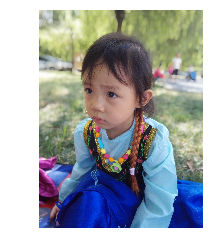

(3264, 2448, 3)


In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import tensorflow as tf

myimg = mpimg.imread('imgs/17_girl.jpg')
plt.imshow(myimg)
plt.axis('off') # 不显示坐标轴
plt.show()
print(myimg.shape)

#### 定义占位符、卷积核、卷积op
这里需要手动将sobel算子填入到卷积核里。使用tf.constant函数可以将常量直接初始化到Variable中，因为是3个通道，所以sobel卷积核的每个元素都扩成了3个。
> sobel算子处理过的图片不保证每个像素都在0~256之间，所以要做一次**归一化操作**（即用每个值减去最小值的结果，再除以最大值与最小值的差），让生成的值都在[0,1]之间，然后再乘以255。

In [13]:
full = np.reshape(myimg,[1,3264,2448,3])
inputfull = tf.Variable(tf.constant(1.0,shape=[1,3264,2448,3]))

filter = tf.Variable(tf.constant([[-1.0,-1.0,-1.0],[0,0,0],[1.0,1.0,1.0],[-2.0,-2.0,-2.0],[0,0,0],[2.0,2.0,2.0],
                                 [-1.0,-1.0,-1.0],[0,0,0],[1.0,1.0,1.0]],shape=[3,3,3,1]))

# 3个通道输入，生成1个feature map
op = tf.nn.conv2d(inputfull,filter,strides=[1,1,1,1],padding='SAME')
o = tf.cast( ((op-tf.reduce_min(op))/(tf.reduce_max(op)-tf.reduce_min(op)))*255,tf.uint8 ) 

上面代码，卷积op的步长为1x1，padding为SAMA表明这是个同卷积的操作。

### 运行卷积操作并显示

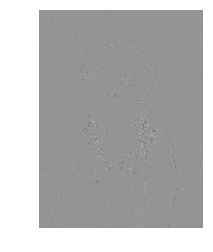

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    t,f=sess.run([o,filter],feed_dict={inputfull:full})
    
    t = np.reshape(t,[3264,2448])
    plt.imshow(t,cmap='Greys_r') #显示图片
    plt.axis('off') #不显示坐标轴
    plt.show()

可以看出，sobel的卷积操作之后，提取到了一张含有轮廓特征的图像。

## 池化函数tf.nn.max_pool(avg_pool)

TensorFlow里的池化函数如下：
___
```python
tf.nn.max_pool(input,ksize,strides,padding,name=None)
tf.nn.avg_pool(input,ksize,strides,padding,name=None)
```
___
- input:需要池化的输入，一般池化层接在卷积的后面，所以输入通常是feature map，依然是[batch,height,width,channels]这样的shape。

- ksize:池化窗口的大小，取一个四维向量，一般是[1,height,width,1]，因为我们不想在batch和channels上做池化，所以这两个维度设为了1。
- strides:和卷积参数含义类似，窗口在每一个维度上滑动的步长，一般是[1,stride,strde,1]。
- padding:‘SAME'或'VALID'。
- 返回一个Tensor，类型不变，shape仍然是[batch,height,width,channels]这种形式。